# Battle of the Neighbourhoods

## Introduction: Bussiness Problem

Toronto is the capital of a Canadian province called Ontario. With a population of 2.7 million, it is known to be the most populous city in Canada and fourth most populated city in North America. The city of Toronto is Toronto is part of the Greater Toronto Area (GTA) which includes the following regions:
- Halton
- Peel
- City of Toronto
- York
- Durham

These regions are further divided into subdivisions called Boroughs. Being the most populated area in Canada, GTA welcomes more than 100,000 immigrants every year. When migrating to a vast area like GTA, immigrants often find themselves in a dilemma when it comes to deciding a location to buy house. They would need to account for all the amenities in their neighbourhood including grocery stores, restaurants, movie theatres, etc. It becomes a bigger issue when a family migrates to GTA. In this case, they would also need to find schools for their children in the neighbourhood. Wouldn't it be convenient for immigrants to know about all neighbourhoods prior to their arrival in order to find a perfect neighbourhood that would suit their lifestyles?

## Data

The data is scraped form a publicly available dataset on Wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). This dataset consists of the following attributes:
-	Postal Codes
-	Borough
-	Neighbourhood

The dataset contains all the subdivisions of GTA along with its neighbourhoods. Google Maps Geocoding API will be leveraged to obtain the latitude and longitude of each neighbourhood. As described in the problem description, venues surrounding each neighbourhood will be retrieved using the Foursquare API. Neighbourhoods will then be clustered based on the venues surrounding then. Each Neighbourhood will be displayed with its most popular venues. A map of GTA will be displayed with similar neighbourhoods giving users more alternatives.

In [351]:
# IMPORT AND INSTALL LIBRARIES
import requests
from bs4 import BeautifulSoup

import numpy as np 
import pandas as pd

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import folium

## Data Scraping

#### Get HTML Code

In [352]:
response = requests.get(url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M",)
soup = BeautifulSoup(response.content, 'html.parser')

#### Print 1st Row

In [353]:
soup.table.tbody.find_all('tr')[1]#.find_all('td')[1].get_text()

<tr>
<td>M1A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>

#### Convert HTML Table to Dataframe

In [354]:
#Create New Dataframe
column_names = ['Postal Code','Borough', 'Neighborhood'] 
toronto = pd.DataFrame(columns=column_names)

In [355]:
table = soup.table.tbody

row_count = 0

for row in table.find_all('tr'):
    new_row=[]
    for column in row.find_all('td'):
        new_row.append(column.get_text().strip('\n'))    
    if (len(new_row) != 0):
        print(new_row)
        toronto.loc[row_count] = new_row
        row_count = row_count + 1


['M1A', 'Not assigned', 'Not assigned']
['M2A', 'Not assigned', 'Not assigned']
['M3A', 'North York', 'Parkwoods']
['M4A', 'North York', 'Victoria Village']
['M5A', 'Downtown Toronto', 'Regent Park, Harbourfront']
['M6A', 'North York', 'Lawrence Manor, Lawrence Heights']
['M7A', 'Downtown Toronto', "Queen's Park, Ontario Provincial Government"]
['M8A', 'Not assigned', 'Not assigned']
['M9A', 'Etobicoke', 'Islington Avenue, Humber Valley Village']
['M1B', 'Scarborough', 'Malvern, Rouge']
['M2B', 'Not assigned', 'Not assigned']
['M3B', 'North York', 'Don Mills']
['M4B', 'East York', 'Parkview Hill, Woodbine Gardens']
['M5B', 'Downtown Toronto', 'Garden District, Ryerson']
['M6B', 'North York', 'Glencairn']
['M7B', 'Not assigned', 'Not assigned']
['M8B', 'Not assigned', 'Not assigned']
['M9B', 'Etobicoke', 'West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale']
['M1C', 'Scarborough', 'Rouge Hill, Port Union, Highland Creek']
['M2C', 'Not assigned', 'Not assigned']
['M3C'

#### Drop 'Borough' cells with 'Not assigned' values

In [356]:
toronto.drop(toronto[toronto.Borough == 'Not assigned'].index, inplace=True)
toronto.reset_index(inplace = True, drop = True)

In [357]:
toronto.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### Assign 'Borough' to 'Neighborhood' if it is 'Not assigned'

In [358]:
toronto['Neighborhood'].loc[(toronto.Neighborhood == 'Not assigned') & (toronto.Borough != 'Not assigned')] = toronto['Borough'].loc[(toronto.Neighborhood == 'Not assigned') & (toronto.Borough != 'Not assigned')]

In [359]:
toronto.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [360]:
toronto.shape

(103, 3)

#### Import Dataset

In [361]:
#Reading in the gespatial data
file='http://cocl.us/Geospatial_data'
geocode=pd.read_csv(file)

#Combine both data frames
toronto=pd.merge(toronto,geocode, on='Postal Code')
toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [362]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto['Borough'].unique()),
        toronto.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


#### Perform Segmentation and Clustering

In [363]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [364]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'], toronto['Neighborhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [365]:
CLIENT_ID = 'YLWZVCOMMJDPT2PFHA0YS4HZFBV2FU1BPIXBHVS5HPOJTKIU' # your Foursquare ID
CLIENT_SECRET = 'BYWVZ4UZAAPFVCYORSLAGTIR1NKSXQ5PEKDDM5JNIZJNDLIL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YLWZVCOMMJDPT2PFHA0YS4HZFBV2FU1BPIXBHVS5HPOJTKIU
CLIENT_SECRET:BYWVZ4UZAAPFVCYORSLAGTIR1NKSXQ5PEKDDM5JNIZJNDLIL


In [366]:
LIMIT = 1000

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [367]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )

In [368]:
print(toronto_venues.shape)
toronto_venues.head(30)

(2124, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
5,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
6,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
7,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
8,"Regent Park, Harbourfront",43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
9,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [369]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
Berczy Park,59,59,59,59,59,59
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17


In [370]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 271 uniques categories.


In [371]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [372]:
toronto_onehot.shape

(2124, 271)

In [373]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00

In [374]:
toronto_grouped.shape

(96, 271)

In [375]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1  Latin American Restaurant  0.25
2             Breakfast Spot  0.25
3               Skating Rink  0.25
4              Metro Station  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1             Gym  0.12
2  Sandwich Place  0.12
3    Skating Rink  0.12
4     Coffee Shop  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0  Coffee Shop  0.11
1         Bank  0.11
2  Pizza Place  0.05
3  Gas Station  0.05
4  Bridal Shop  0.05


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Café  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4  Moroccan Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.08
1  Italian Restaurant  0.08
2         Coffee Shop  0.08
3     Thai Restaurant  0.08
4    Toy / Game Store  0.04

                           venue  freq
0                           Café  0.08
1                    Coffee Shop  0.06
2  Vegetarian / Vegan Restaurant  0.06
3             Mexican Restaurant  0.05
4          Vietnamese Restaurant  0.05


----Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens----
               venue  freq
0     Sandwich Place  0.25
1               Park  0.25
2           Bus Line  0.25
3  Mobile Phone Shop  0.25
4      Metro Station  0.00


----Lawrence Manor, Lawrence Heights----
                 venue  freq
0       Clothing Store  0.31
1        Women's Store  0.08
2  Sporting Goods Shop  0.08
3             Boutique  0.08
4   Miscellaneous Shop  0.08


----Lawrence Park----
         venue  freq
0         Park  0.25
1     Bus Line  0.25
2       Lawyer  0.25
3  Swim School  0.25
4  Yoga Studio  0.00


----Leaside----
                 venue  freq
0          Coffee Shop  0.09
1  Sporting Goods Shop  0.09
2         Burger Joint  0.06
3        Shopping Mal

4     Shopping Mall  0.06


----Willowdale, Willowdale West----
            venue  freq
0        Pharmacy   0.2
1     Pizza Place   0.2
2   Grocery Store   0.2
3     Coffee Shop   0.2
4  Discount Store   0.2


----Woburn----
                   venue  freq
0            Coffee Shop   0.4
1               Pharmacy   0.2
2  Korean BBQ Restaurant   0.2
3           Soccer Field   0.2
4   Other Great Outdoors   0.0


----Woodbine Heights----
                venue  freq
0        Intersection  0.14
1         Curling Ice  0.14
2                Park  0.14
3  Athletics & Sports  0.14
4          Beer Store  0.14


----York Mills West----
                        venue  freq
0           Convenience Store   0.5
1                        Park   0.5
2                 Men's Store   0.0
3  Modern European Restaurant   0.0
4           Mobile Phone Shop   0.0


----York Mills, Silver Hills----
                             venue  freq
0                        Cafeteria   1.0
1               Mexican Restaurant 

In [376]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [377]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Lounge,Latin American Restaurant,Skating Rink,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Skating Rink,Pub,Sandwich Place,Pool,Women's Store,Dim Sum Restaurant,Deli / Bodega
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Diner,Pharmacy,Deli / Bodega,Fried Chicken Joint,Middle Eastern Restaurant,Shopping Mall,Supermarket,Pizza Place
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Women's Store,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Thai Restaurant,Indian Restaurant,American Restaurant,Sushi Restaurant,Hobby Shop,Pizza Place,Pharmacy


In [378]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [379]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto

# merge toronto_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,Park,Food & Drink Shop,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Event Space
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Hockey Arena,French Restaurant,Coffee Shop,Portuguese Restaurant,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Pub,Bakery,Park,Café,Theater,Breakfast Spot,Event Space,Restaurant,Performing Arts Venue
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Women's Store,Accessories Store,Event Space,Vietnamese Restaurant,Coffee Shop,Boutique,Miscellaneous Shop,Sporting Goods Shop,Furniture / Home Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Burrito Place,Bar,Italian Restaurant,Japanese Restaurant,Beer Bar,Smoothie Shop,Sandwich Place


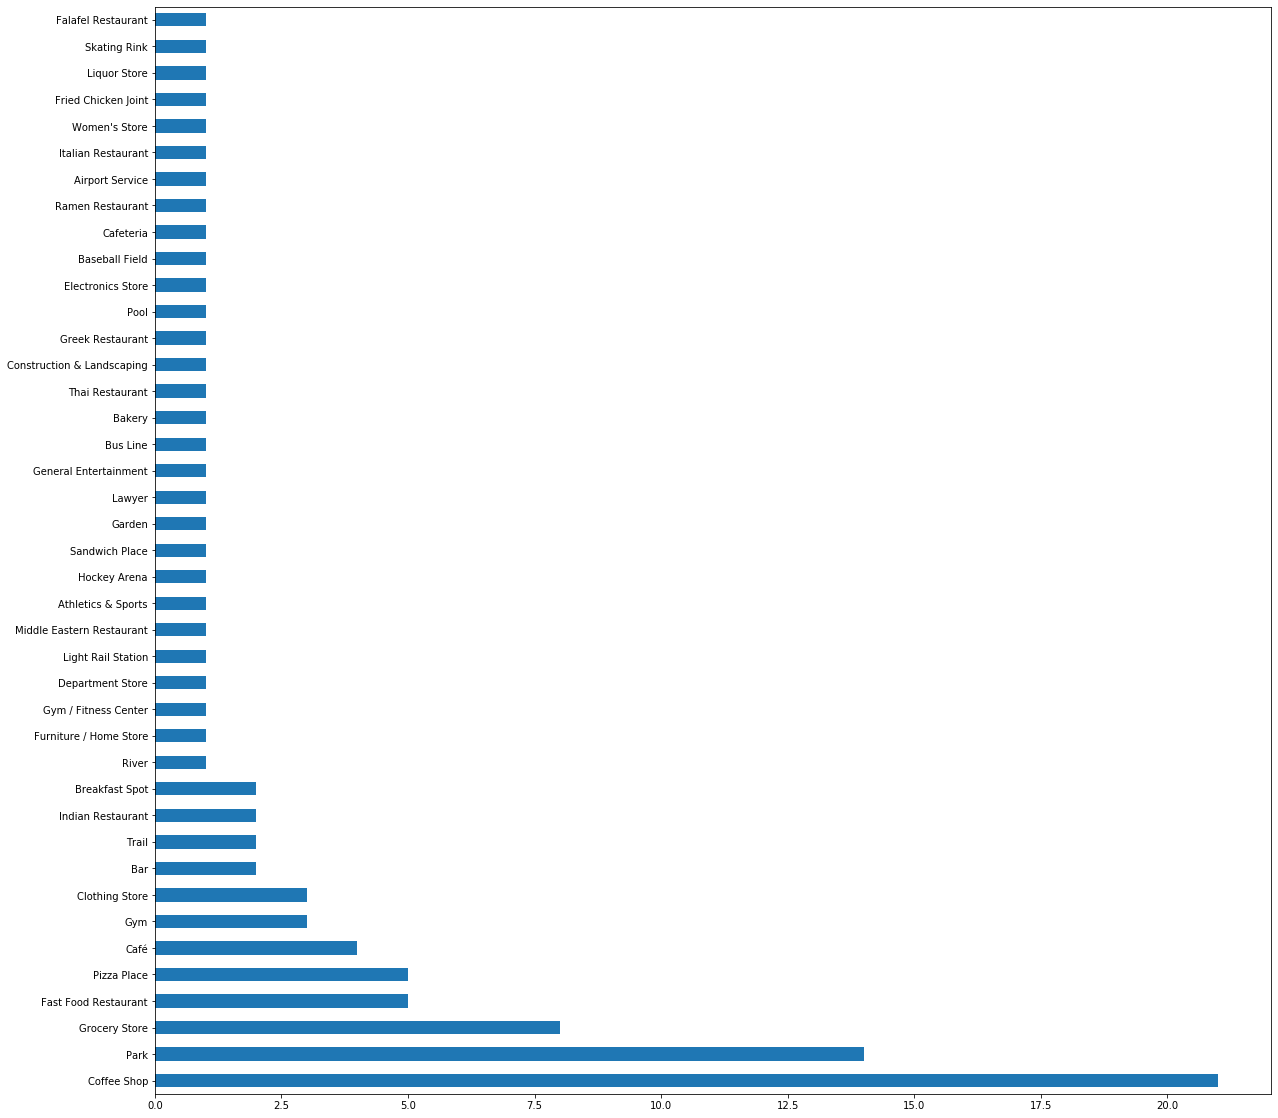

In [380]:
#Show Histogram for 1st Most Common Venue

plt.figure(figsize=(20,20))
toronto_merged["1st Most Common Venue"].value_counts().plot.barh()
plt.show()

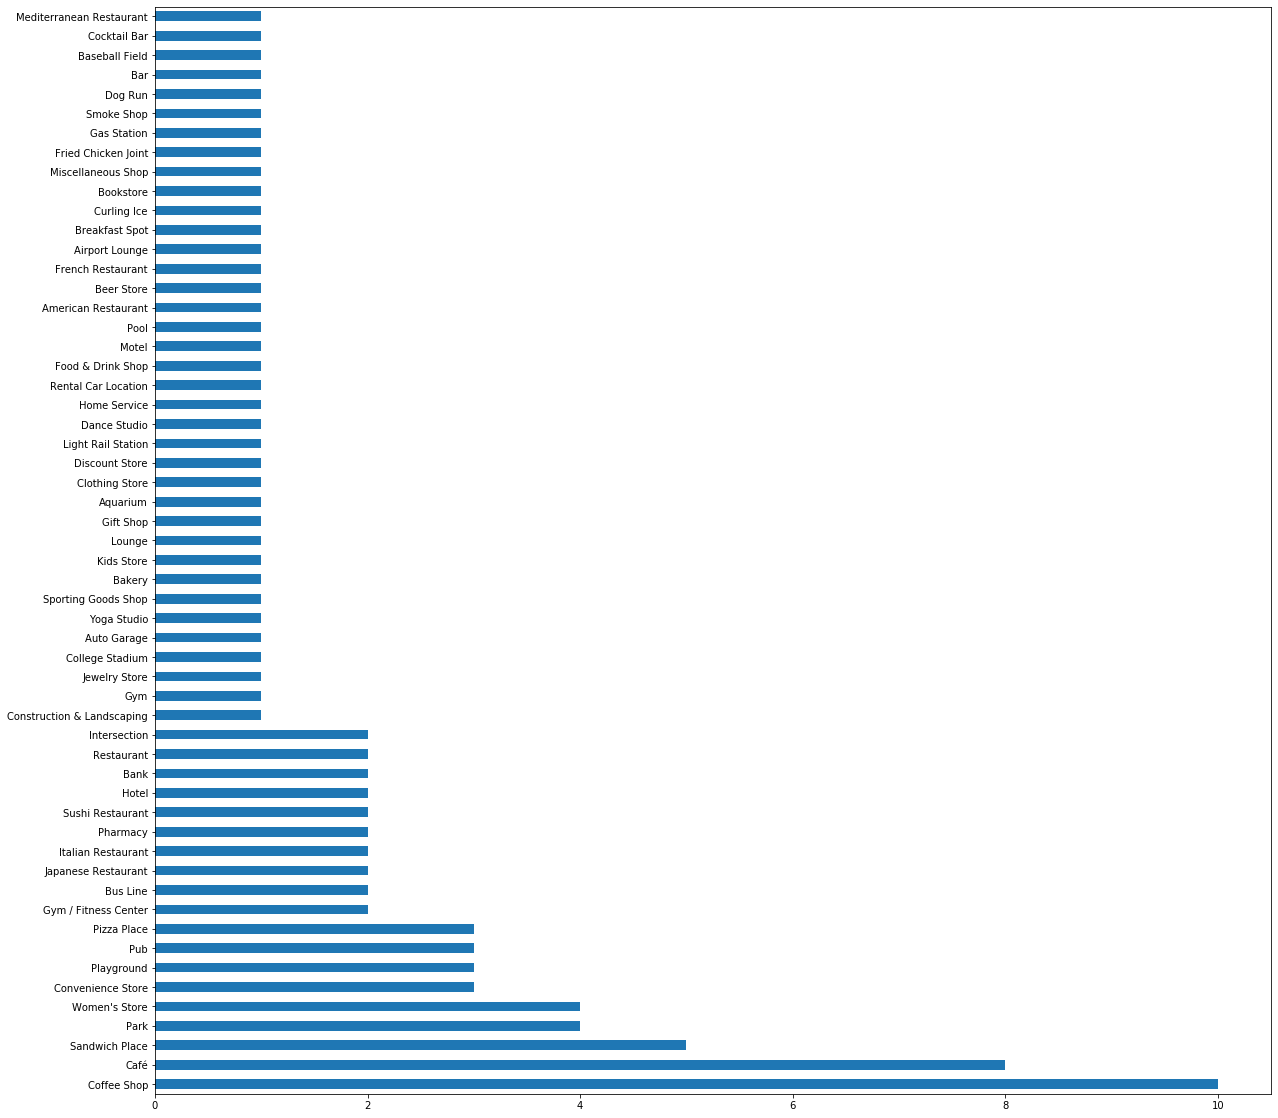

In [381]:
plt.figure(figsize=(20,20))
toronto_merged["2nd Most Common Venue"].value_counts().plot.barh()
plt.show()

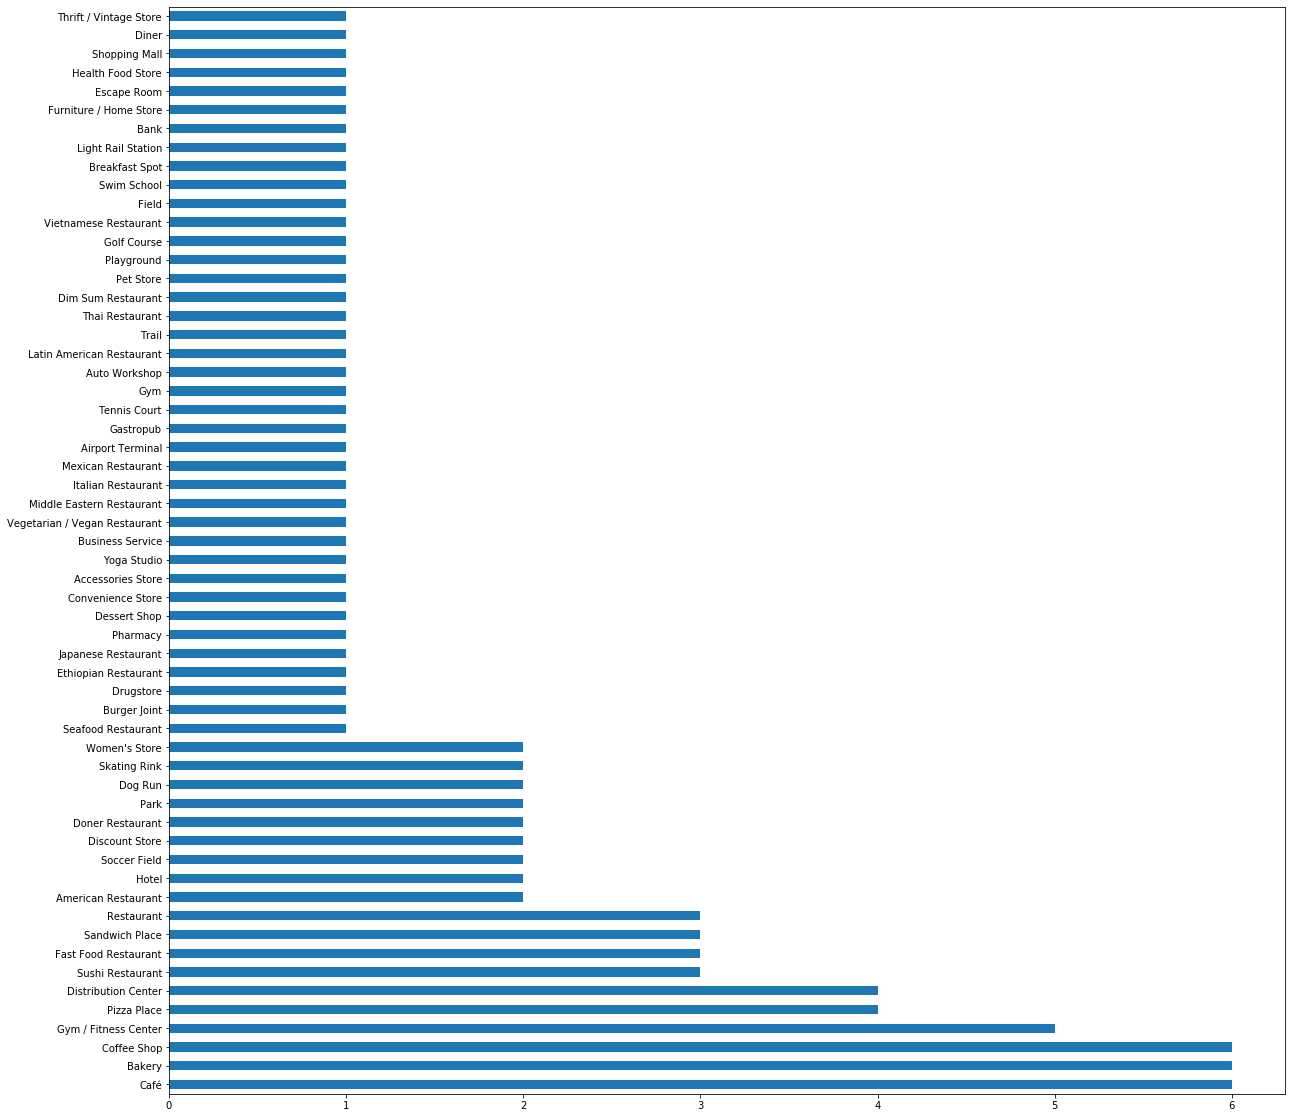

In [382]:
plt.figure(figsize=(20,20))
toronto_merged["3rd Most Common Venue"].value_counts().plot.barh()
plt.show()

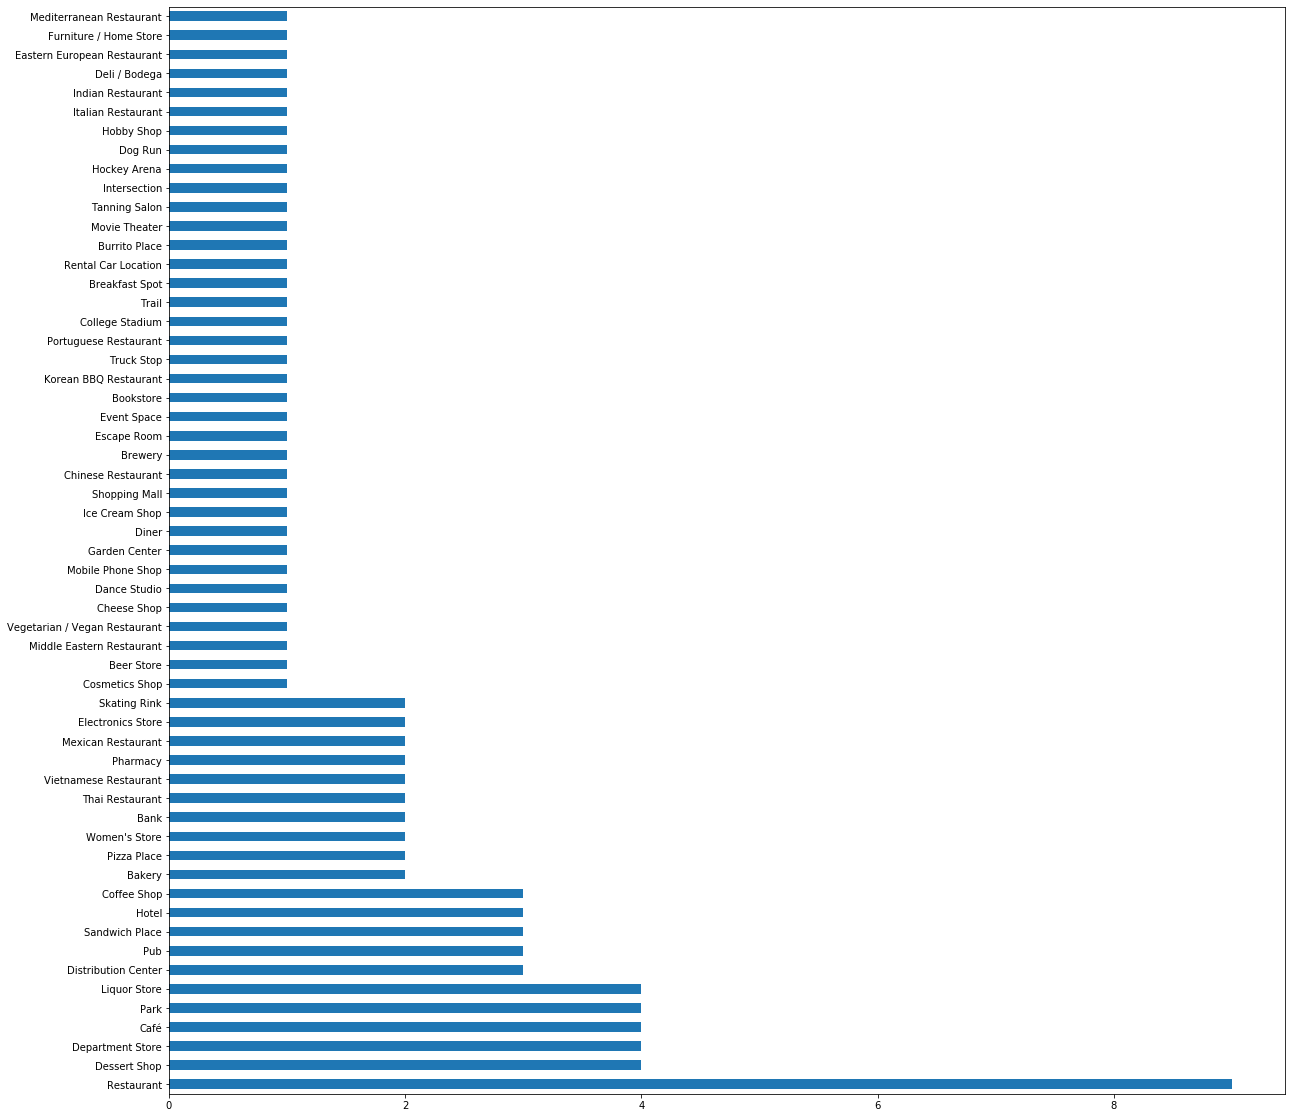

In [383]:
plt.figure(figsize=(20,20))
toronto_merged["4th Most Common Venue"].value_counts().plot.barh()
plt.show()

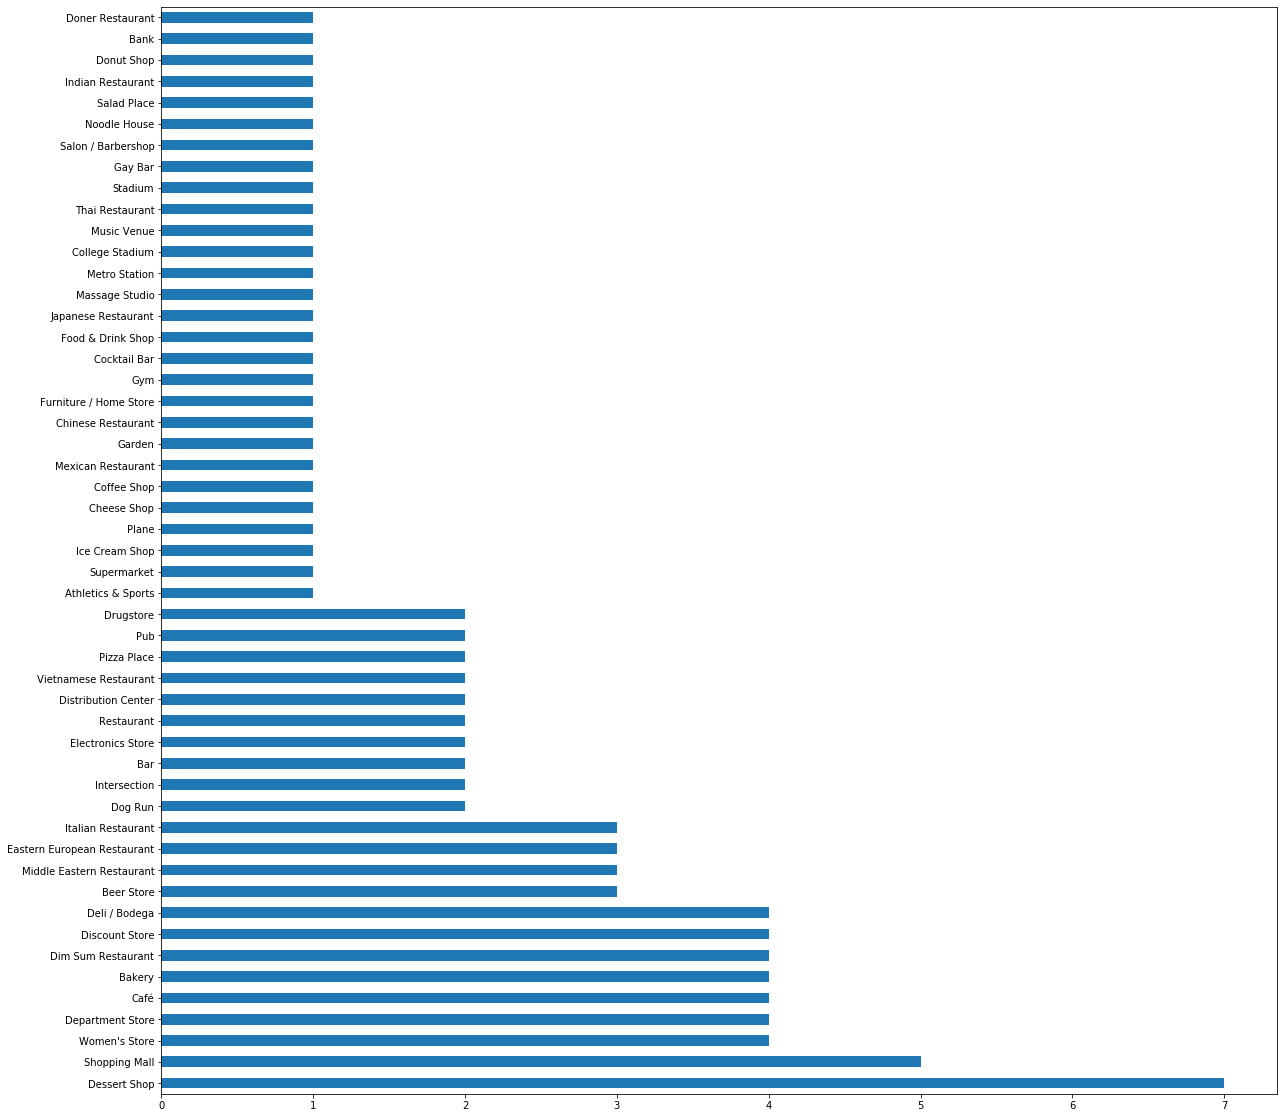

In [384]:
plt.figure(figsize=(20,20))
toronto_merged["5th Most Common Venue"].value_counts().plot.barh()
plt.show()

In [385]:
toronto_merged.dropna(how='any', inplace=True)
toronto_merged.reset_index(inplace = True, drop = True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(np.int64)
toronto_merged.head(20)

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Park,Food & Drink Shop,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Event Space
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Hockey Arena,French Restaurant,Coffee Shop,Portuguese Restaurant,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Bakery,Park,Café,Theater,Breakfast Spot,Event Space,Restaurant,Performing Arts Venue
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Women's Store,Accessories Store,Event Space,Vietnamese Restaurant,Coffee Shop,Boutique,Miscellaneous Shop,Sporting Goods Shop,Furniture / Home Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Burrito Place,Bar,Italian Restaurant,Japanese Restaurant,Beer Bar,Smoothie Shop,Sandwich Place
5,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4,Fast Food Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
6,M3B,North York,Don Mills,43.745906,-79.352188,0,Gym,Coffee Shop,Café,Restaurant,Beer Store,Japanese Restaurant,Supermarket,Clothing Store,Chinese Restaurant,Caribbean Restaurant
7,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0,Pizza Place,Gym / Fitness Center,Gastropub,Café,Athletics & Sports,Bank,Flea Market,Bus Line,Intersection,Pharmacy
8,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Hotel,Middle Eastern Restaurant,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Lingerie Store,Theater
9,M6B,North York,Glencairn,43.709577,-79.445073,0,Park,Sushi Restaurant,Pizza Place,Bakery,Pub,Japanese Restaurant,Women's Store,Diner,Department Store,Dessert Shop


In [386]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [387]:
toronto_merged[toronto_merged['Cluster Labels'] == 0]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Hockey Arena,French Restaurant,Coffee Shop,Portuguese Restaurant,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Bakery,Park,Café,Theater,Breakfast Spot,Event Space,Restaurant,Performing Arts Venue
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Women's Store,Accessories Store,Event Space,Vietnamese Restaurant,Coffee Shop,Boutique,Miscellaneous Shop,Sporting Goods Shop,Furniture / Home Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Burrito Place,Bar,Italian Restaurant,Japanese Restaurant,Beer Bar,Smoothie Shop,Sandwich Place
6,M3B,North York,Don Mills,43.745906,-79.352188,0,Gym,Coffee Shop,Café,Restaurant,Beer Store,Japanese Restaurant,Supermarket,Clothing Store,Chinese Restaurant,Caribbean Restaurant
7,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0,Pizza Place,Gym / Fitness Center,Gastropub,Café,Athletics & Sports,Bank,Flea Market,Bus Line,Intersection,Pharmacy
8,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Hotel,Middle Eastern Restaurant,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Lingerie Store,Theater
9,M6B,North York,Glencairn,43.709577,-79.445073,0,Park,Sushi Restaurant,Pizza Place,Bakery,Pub,Japanese Restaurant,Women's Store,Diner,Department Store,Dessert Shop
10,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0,Construction & Landscaping,Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store,Department Store
11,M3C,North York,Don Mills,43.725900,-79.340923,0,Gym,Coffee Shop,Café,Restaurant,Beer Store,Japanese Restaurant,Supermarket,Clothing Store,Chinese Restaurant,Caribbean Restaurant


In [388]:
toronto_merged[toronto_merged['Cluster Labels'] == 1]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Park,Food & Drink Shop,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Event Space
19,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,1,Park,Pool,Women's Store,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Escape Room,Dance Studio
33,M4J,East York,"East Toronto, Broadview North (Old East York)",43.685347,-79.338106,1,Park,Intersection,Convenience Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Deli / Bodega
47,M6L,North York,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,1,Park,Construction & Landscaping,Bakery,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Deli / Bodega
50,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,1,Park,Dance Studio,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
62,M9N,York,Weston,43.706876,-79.518188,1,Park,Convenience Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dance Studio
64,M2P,North York,York Mills West,43.752758,-79.400049,1,Park,Convenience Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dance Studio
66,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307,1,Park,Jewelry Store,Sushi Restaurant,Trail,Drugstore,Donut Shop,Doner Restaurant,Eastern European Restaurant,Dog Run,Dance Studio
81,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,1,Park,Playground,Tennis Court,Restaurant,Donut Shop,Doner Restaurant,Dog Run,Drugstore,Distribution Center,Cupcake Shop
83,M1V,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,1,Park,Intersection,Playground,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


In [389]:
toronto_merged[toronto_merged['Cluster Labels'] == 2]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,M2L,North York,"York Mills, Silver Hills",43.75749,-79.374714,2,Cafeteria,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Deli / Bodega


In [390]:
toronto_merged[toronto_merged['Cluster Labels'] == 3]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
55,M9M,North York,"Humberlea, Emery",43.724766,-79.532242,3,Furniture / Home Store,Baseball Field,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Deli / Bodega,Doner Restaurant
98,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,3,Baseball Field,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop


In [391]:
toronto_merged[toronto_merged['Cluster Labels'] == 4]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4,Fast Food Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
54,M6M,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,4,Fast Food Restaurant,Sandwich Place,Discount Store,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run


In [392]:
toronto_venues['Venue Category'].unique()

array(['Park', 'Food & Drink Shop', 'Hockey Arena', 'Coffee Shop',
       'Portuguese Restaurant', 'French Restaurant', 'Bakery',
       'Distribution Center', 'Spa', 'Restaurant', 'Breakfast Spot',
       'Gym / Fitness Center', 'Historic Site', 'Chocolate Shop',
       'Farmers Market', 'Performing Arts Venue', 'Dessert Shop', 'Pub',
       'Event Space', 'Mexican Restaurant', 'Yoga Studio', 'Café',
       'Theater', 'Shoe Store', 'Brewery', 'Art Gallery',
       'Cosmetics Shop', 'Electronics Store', 'Beer Store', 'Bank',
       'Hotel', 'Health Food Store', 'Antique Shop', 'Boutique',
       'Furniture / Home Store', 'Vietnamese Restaurant',
       'Clothing Store', 'Accessories Store', "Women's Store",
       'Miscellaneous Shop', 'Sporting Goods Shop', 'Italian Restaurant',
       'Creperie', 'Sushi Restaurant', 'Beer Bar', 'Hobby Shop', 'Diner',
       'Burrito Place', 'Fried Chicken Joint', 'Nightclub',
       'Japanese Restaurant', 'Smoothie Shop', 'Sandwich Place', 'Gym',
   

In [393]:
array=['Baseball Field']

bestNB = toronto_merged[np.isin(toronto_merged, array).any(axis=1)]
bestNB

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,M3K,North York,Downsview,43.737473,-79.464763,0,Grocery Store,Park,Gym / Fitness Center,Liquor Store,Shopping Mall,Bank,Food Truck,Athletics & Sports,Baseball Field,Discount Store
44,M3L,North York,Downsview,43.739015,-79.506944,0,Grocery Store,Park,Gym / Fitness Center,Liquor Store,Shopping Mall,Bank,Food Truck,Athletics & Sports,Baseball Field,Discount Store
51,M3M,North York,Downsview,43.728496,-79.495697,0,Grocery Store,Park,Gym / Fitness Center,Liquor Store,Shopping Mall,Bank,Food Truck,Athletics & Sports,Baseball Field,Discount Store
55,M9M,North York,"Humberlea, Emery",43.724766,-79.532242,3,Furniture / Home Store,Baseball Field,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Deli / Bodega,Doner Restaurant
58,M3N,North York,Downsview,43.761631,-79.520999,0,Grocery Store,Park,Gym / Fitness Center,Liquor Store,Shopping Mall,Bank,Food Truck,Athletics & Sports,Baseball Field,Discount Store
98,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,3,Baseball Field,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop


In [394]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bestNB['Latitude'], bestNB['Longitude'], bestNB['Neighborhood'], bestNB['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Conclusion

As seen above, any immigrant moving to Toronto can enter the amenities and get a list of best suited neighbourhoods and display their locations on a map.  This will help the user understand the types of neigbourhoods in Toronto. Moreover, this model could be applied to cities other than Toronto and help anyone who is planning to move to that city.